Analysis of the incoming velocity over the shelf on the upstream side of the canyon, identifying the time-dependent and advection driven stages.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions


from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

from matplotlib.ticker import MultipleLocator

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [3]:
def U_timeseries(dirname, fname, x_start, x_end, y_start, y_end):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    
    y = slice(y_start, y_end, None)
    x = slice(x_start, x_end, None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,:,y,x]
        print('V')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        sometauy = dsV.variables['sometauy'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]

    umask = np.tile(umask0, (len(sozotaux),1, 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux),1, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vozocrtx, vomecrty, umask, vmask, depthu, sozotaux

In [4]:
def get_speeds(U_vel, V_vel, dep, time_ind, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[time_ind, dep, :, :]
    vgrid = V_vel[time_ind, dep, :, :]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return speeds

## Parent bathymetry

In [5]:
bfile = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
bathy = bfile['Bathymetry'][:]
xsb = np.arange(bathy.shape[-1])
ysb = np.arange(bathy.shape[-2])

## Complete masks

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
    umask_all = dsM.variables['umask'][0,:,:,:]
    vmask_all = dsM.variables['vmask'][0,:,:,:]

## Incoming velocity time series

In [7]:
#dirname='/ocean/imachuca/Canyons/results_mackenzie/ideal_double_flt/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

In [8]:
x_start = 200
x_end = 230
y_start = 45
y_end = 190

x_axis=110

In [9]:
vozocrtx, vomecrty, umask, vmask, depthu, sozotaux = U_timeseries(dirname, fname, x_start, x_end, y_start, y_end)

U
V


## Child masks at depths

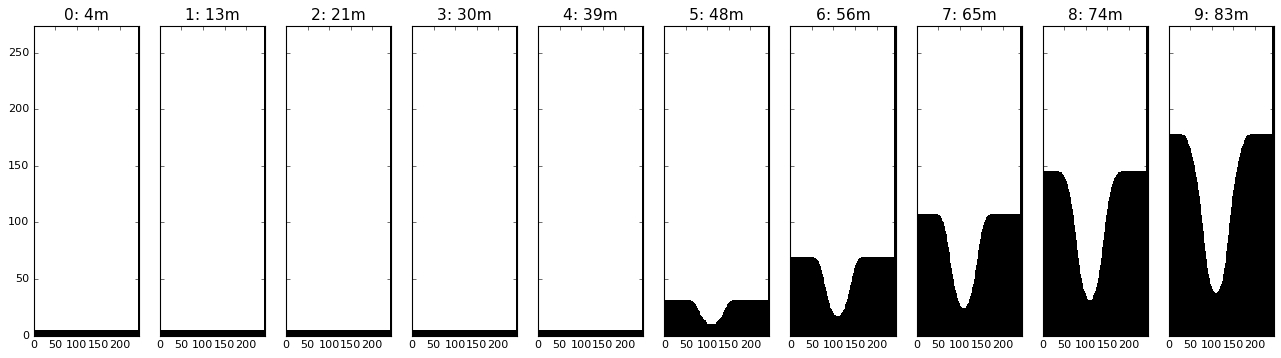

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(20,5), sharey=True)
for ax, n in zip(axes.flatten(), np.arange(10)):
    ax.pcolormesh(umask_all[n, :,:], cmap=cm.binary_r)
    ax.set_ylim([0, umask_all.shape[-2]])
    ax.set_xlim([0, umask_all.shape[-1]])
    ax.set_title(str(n) + ': ' + str(int(depthu[n])) + 'm', fontsize=14)

## Positioning of incoming velocity region

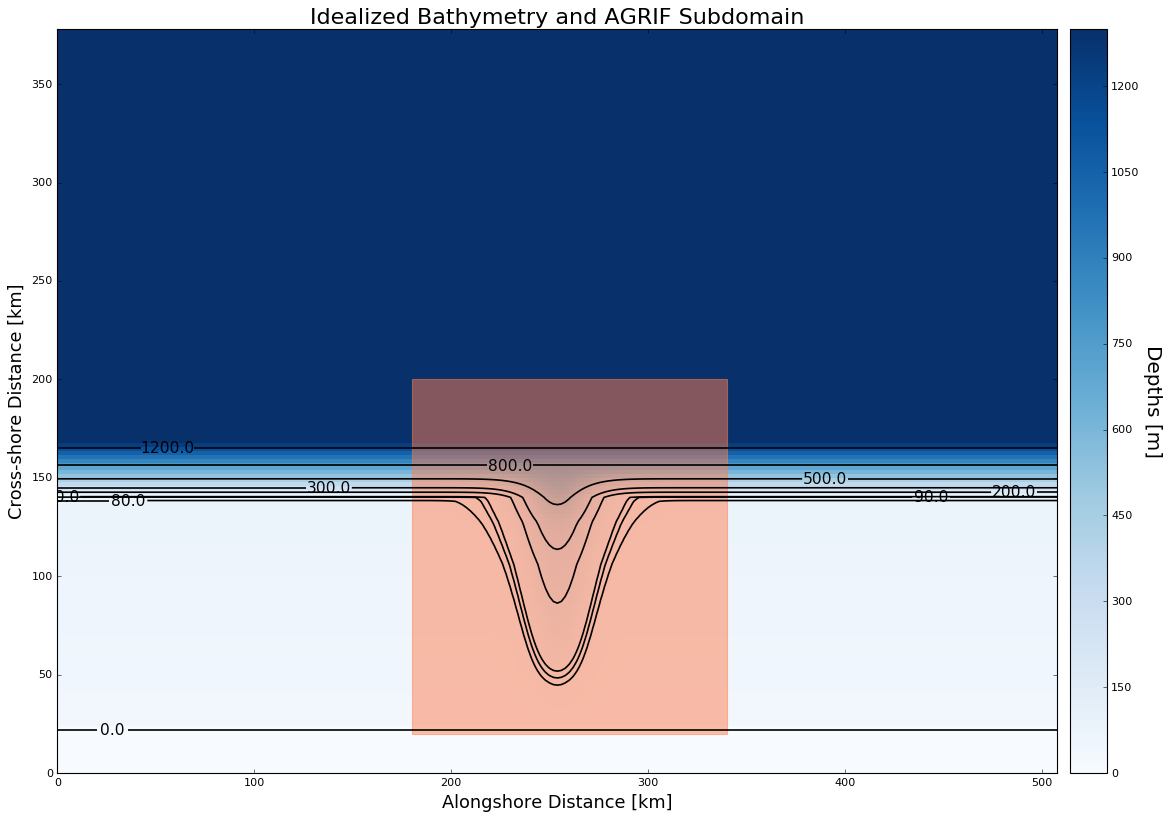

In [11]:
fig, ax1 = plt.subplots(1,1,figsize=(20, 12))
c = ax1.contour(xsb*2, ysb*2, bathy, levels = [0,80,90,100,200,300,500,800,1200],colors='k',linewidths=1.5)
s = ax1.pcolormesh(xsb*2, ysb*2, bathy, cmap=cm.Blues,)
ax1.add_patch(patches.Rectangle((90*2, 10*2),80*2,90*2, color='coral', alpha=0.5)) #90 170 10 100
ax1.set_title('Idealized Bathymetry and AGRIF Subdomain', fontsize=20)
ax1.set_aspect(aspect='equal')
ax1.set_ylabel('Cross-shore Distance [km]', fontsize=16)
ax1.set_xlabel('Alongshore Distance [km]', fontsize=16)
ax1.clabel(c, inline=True, fmt='%1.1f', fontsize=14)
cbar = fig.colorbar(s, ax=ax1, pad = 0.01)
cbar.set_label('Depths [m]', fontsize=18, rotation=270, labelpad=20)
fig.savefig('bathy_and_agrif.png', dpi=fig.dpi)

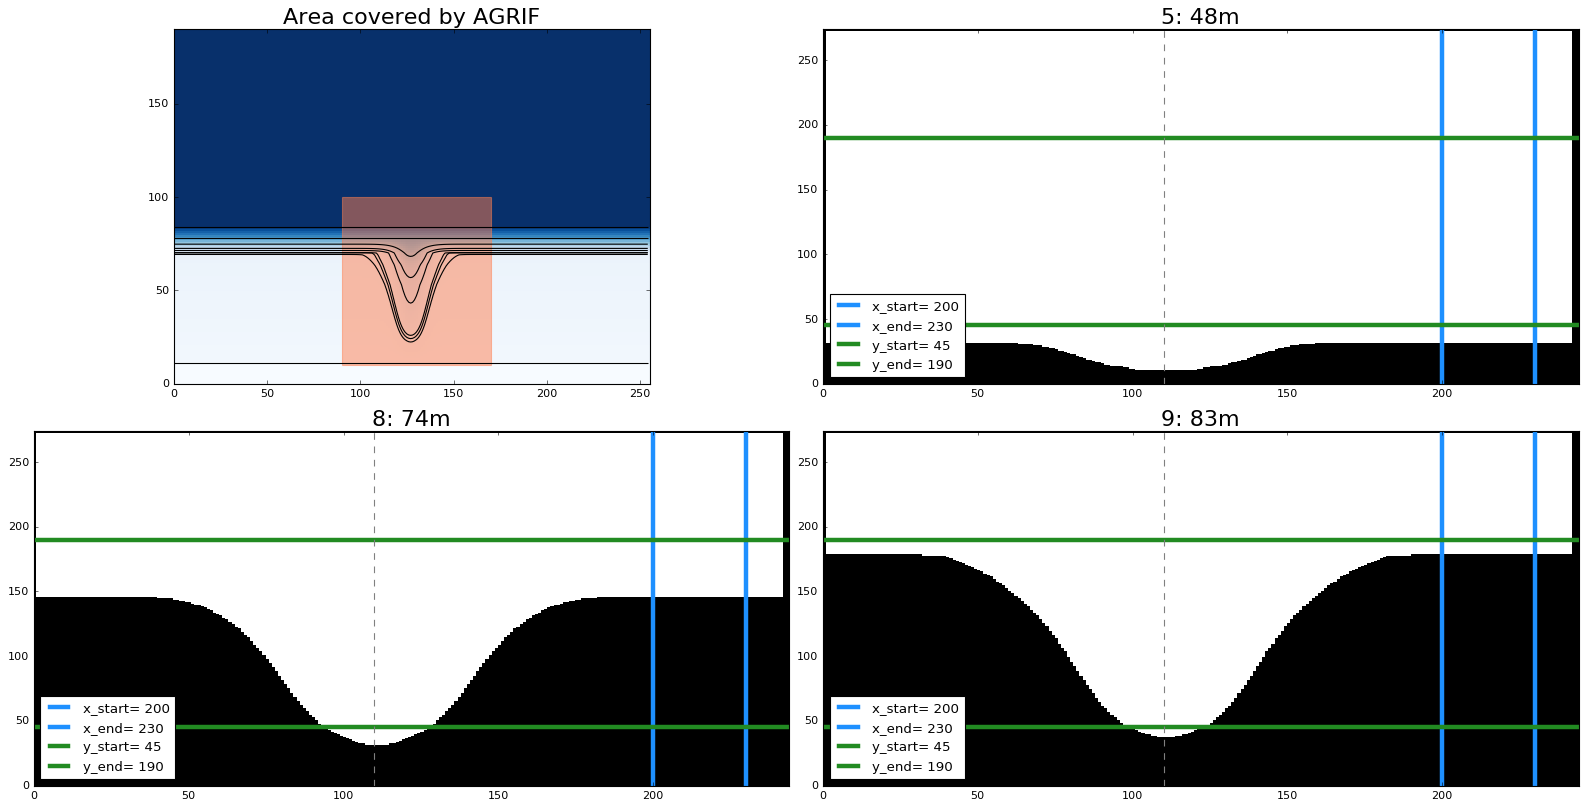

In [12]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20, 10))
fig.tight_layout(w_pad=0.2, h_pad=2.5)

ax1.contour(xsb, ysb, bathy, levels = [0,80,90,100,200,300,500,800,1299],colors='k')
ax1.pcolormesh(bathy, cmap=cm.Blues)
ax1.add_patch(patches.Rectangle((90, 10),80,90, color='coral', alpha=0.5)) #90 170 10 100
ax1.set_title('Area covered by AGRIF', fontsize=20)
ax1.set_aspect(aspect='equal')

lw=4
for dep_ind, ax, n in zip([5, 8, 9], [ax2, ax3, ax4], np.arange(3)):
    ax.pcolormesh(umask_all[dep_ind, :,:], cmap=cm.binary_r)
    ax.set_ylim([0, umask_all.shape[-2]])
    ax.set_xlim([0, umask_all.shape[-1]])
    ax.set_title(str(dep_ind) + ': ' + str(int(depthu[dep_ind])) + 'm', fontsize=20)
    ax.axvline(x_start, c='dodgerblue', linewidth=lw, label='x_start= '+str(x_start))
    ax.axvline(x_end, c='dodgerblue', linewidth=lw, label='x_end= '+str(x_end))
    ax.axhline(y_start, c='forestgreen', linewidth=lw, label='y_start= '+str(y_start))
    ax.axhline(y_end, c='forestgreen', linewidth=lw, label='y_end= '+str(y_end))
    ax.legend(loc=3)
    ax.axvline(x_axis, c='gray', linestyle='--')

## Finding average U, V, speeds

In [13]:
speeds_all = np.ones([480, 80, y_end-y_start-1, x_end-x_start-1])

for dep_ind in np.arange(80):
    for time_ind in np.arange(480):
        speeds = get_speeds(vozocrtx, vomecrty, dep_ind, time_ind, 1)
        speeds_all[time_ind, dep_ind, :, :] = speeds

In [69]:
avgU = np.mean(np.mean(vozocrtx, axis=-1), axis=-1)
avgV = np.mean(np.mean(vomecrty, axis=-1), axis=-1)
avgS = np.mean(np.mean(speeds_all, axis=-1), axis=-1)

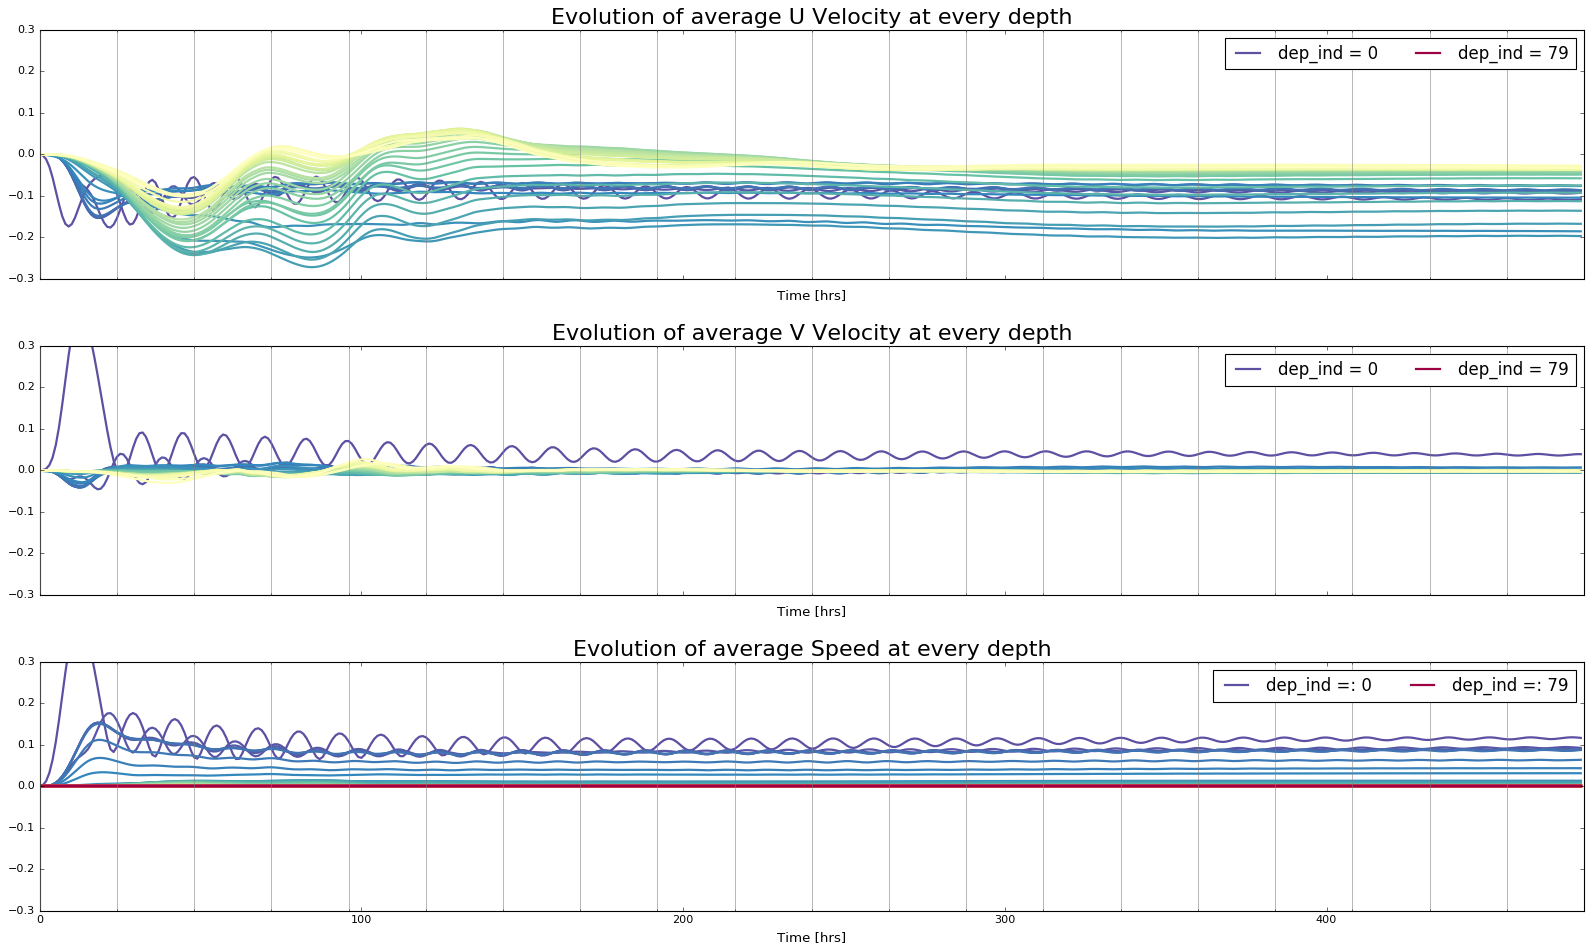

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
cm_times = np.linspace(0, 1, 80)
colors = [cm.Spectral_r(x) for x in cm_times]

for dep_ind, c in zip(np.arange(80), colors):
    if dep_ind == 0 or dep_ind == 79:
        ax1.plot(avgU[:, dep_ind], c=c, lw=2, label='dep_ind = '+str(dep_ind))
        ax2.plot(avgV[:, dep_ind], c=c, lw=2, label='dep_ind = '+str(dep_ind))
        ax3.plot(avgS[:, dep_ind], c=c, lw=2, label='dep_ind =: '+str(dep_ind)) 
    else:
        ax1.plot(avgU[:, dep_ind], c=c, lw=2)
        ax2.plot(avgV[:, dep_ind], c=c, lw=2)
        ax3.plot(avgS[:, dep_ind], c=c, lw=2)

for ax, ttl in zip([ax1, ax2, ax3], ['U Velocity','V Velocity','Speed']):
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.3, 0.3])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.set_title('Evolution of average '+ttl+' at every depth', fontsize=20)
    ax.set_xlabel('Time [hrs]', fontsize=12)
    ax.legend(ncol=2, fontsize=15)
fig.tight_layout(h_pad=2)

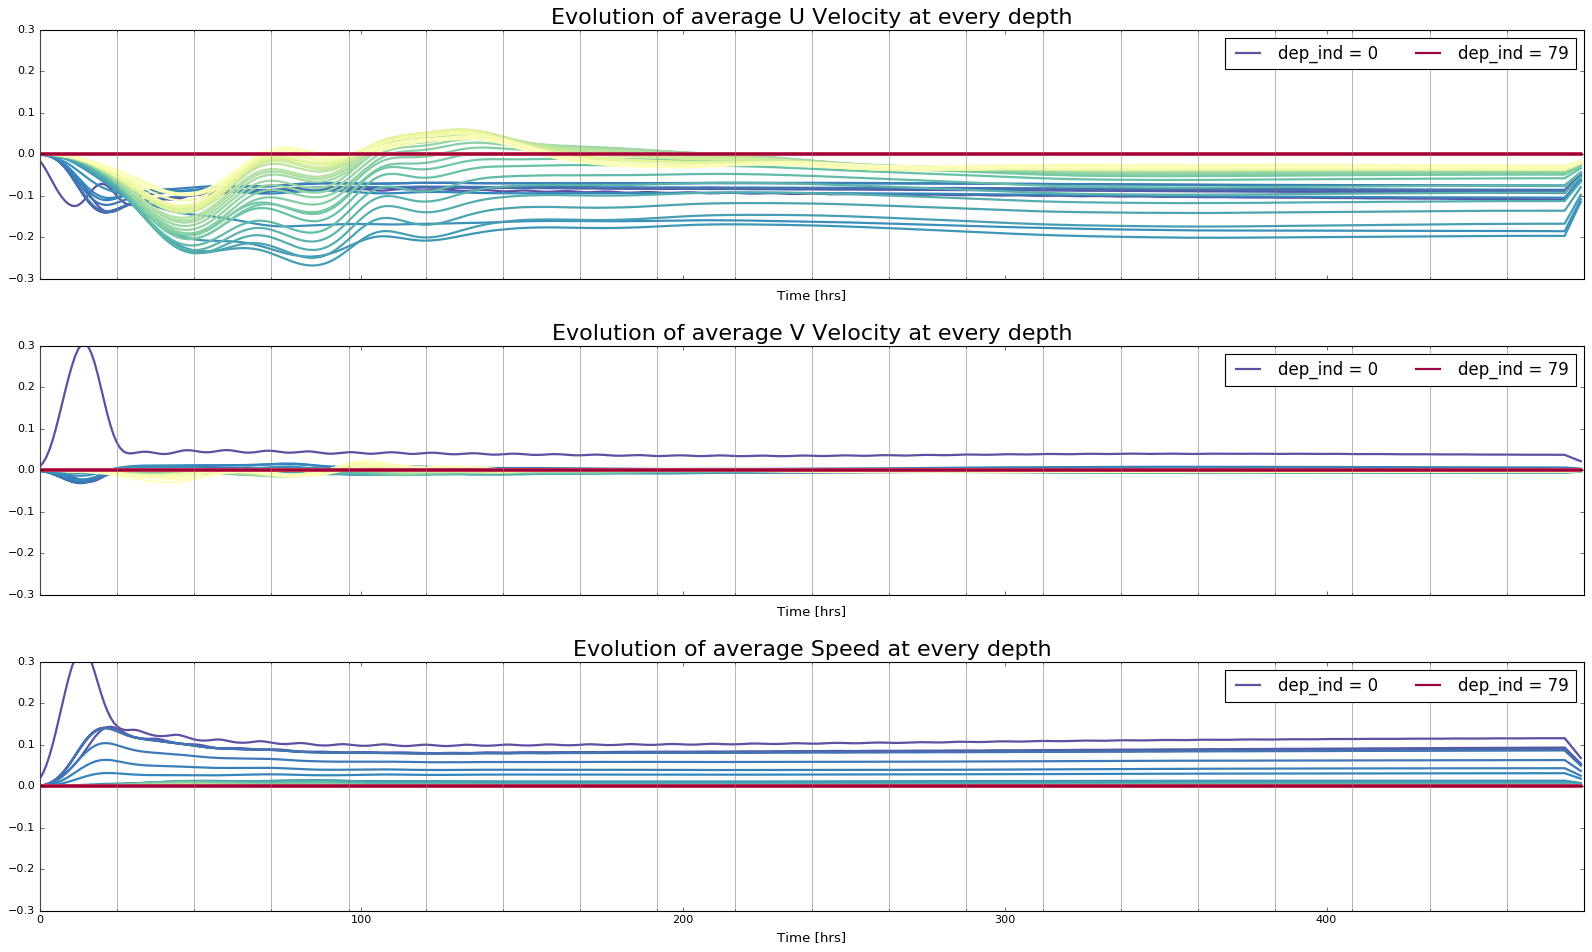

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
cm_times = np.linspace(0, 1, 80)
colors = [cm.Spectral_r(x) for x in cm_times]

for dep_ind, c in zip(np.arange(80), colors):
    if dep_ind == 0 or dep_ind == 79:
        ax1.plot(general_functions.smooth(avgU[:, dep_ind], 12), c=c, lw=2, label='dep_ind = '+str(dep_ind))
        ax2.plot(general_functions.smooth(avgV[:, dep_ind], 12), c=c, lw=2, label='dep_ind = '+str(dep_ind))
        ax3.plot(general_functions.smooth(avgS[:, dep_ind], 12), c=c, lw=2, label='dep_ind = '+str(dep_ind))
    else:
        ax1.plot(general_functions.smooth(avgU[:, dep_ind], 12), c=c, lw=2)
        ax2.plot(general_functions.smooth(avgV[:, dep_ind], 12), c=c, lw=2)
        ax3.plot(general_functions.smooth(avgS[:, dep_ind], 12), c=c, lw=2)

for ax, ttl in zip([ax1, ax2, ax3], ['U Velocity','V Velocity','Speed']):
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.3, 0.3])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.set_title('Evolution of average '+ttl+' at every depth', fontsize=20)
    ax.set_xlabel('Time [hrs]', fontsize=12)
    ax.legend(ncol=2, fontsize=15)
fig.tight_layout(h_pad=2)

## Depth profiles of U 

In [72]:
def U_profile(dirname, fname, time_ind):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    
    y = slice(1, -1, None)
    x = slice(1, -1, None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind,:,y,x]
        sozotaux = dsU.variables['sozotaux'][:,0,0]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask = dsM.variables['umask'][0,:,y,x]

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    return vozocrtx

In [73]:
vozocrtx_day3 = U_profile(dirname, fname, 72)
vozocrtx_day4 = U_profile(dirname, fname, 96)
vozocrtx_day8 = U_profile(dirname, fname, 24*8)
vozocrtx_day15 = U_profile(dirname, fname, 24*15)

In [74]:
xs = np.arange(vozocrtx_day3.shape[-1])
ys = np.arange(vozocrtx_day3.shape[-2])
zs = np.arange(vozocrtx_day3.shape[-3])

In [75]:
dep_ind0, dep_ind1, dep_ind2, dep_ind3, dep_ind4 = 0, 1, 2, 3, 4
dep_ind5, dep_ind6, dep_ind7, dep_ind8, dep_ind9 = 5, 6, 7, 8, 9

dep_start = dep_ind2
dep_end = dep_ind6
dep_break = dep_ind9

In [76]:
def plot_crossU(x_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15):
    fig, axes = plt.subplots(2,2,figsize=(20, 12), sharex=True, sharey=True)
    fig.tight_layout(h_pad=2, w_pad=0.2)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    vels = [vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15]
    ttls = ['day 3', 'day 4', 'day 8', 'day 12']
    for ax, vel, ttl, n in zip(axes.flatten(), vels, ttls, np.arange(4)):
        p = ax.pcolormesh(ys, zs, vel[:, :, x_ind], cmap=cmap, vmin=-0.5, vmax=0.5)
        ax.set_ylim([80, 0])
        ax.set_xlim([0, vel.shape[-2]])
        fig.colorbar(p, ax=ax)
        ax.set_title(ttl, fontsize=20)
        ax.add_patch(patches.Rectangle((y_start, dep_start),y_end-y_start, dep_end-dep_start, fill=False, linewidth=3))
    return fig

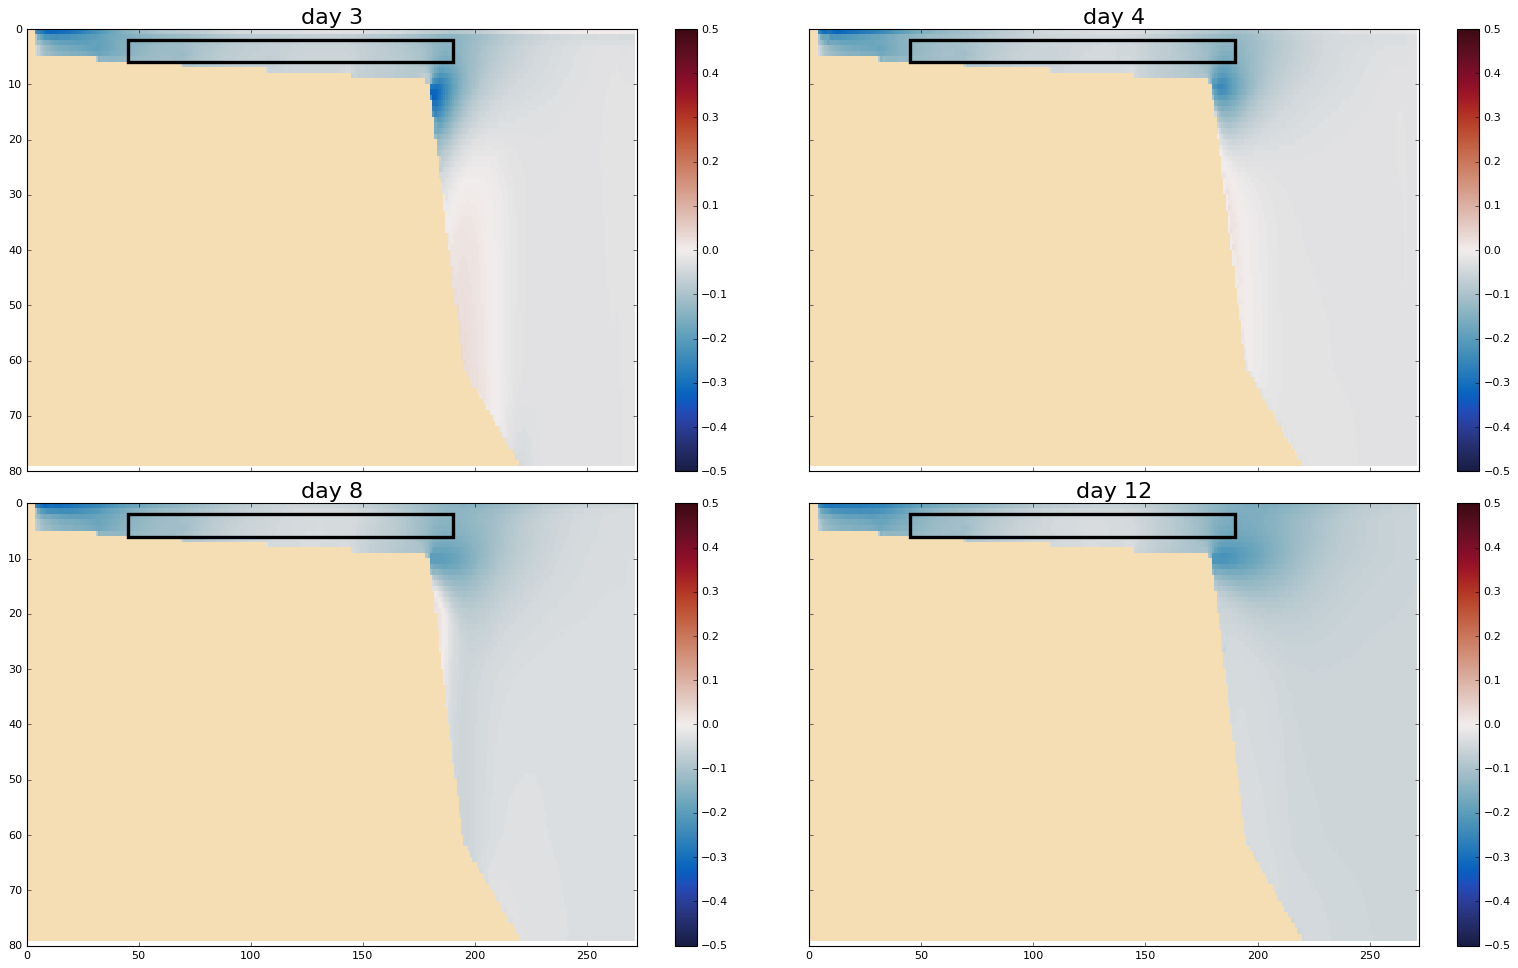

In [77]:
fig = plot_crossU(x_start, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

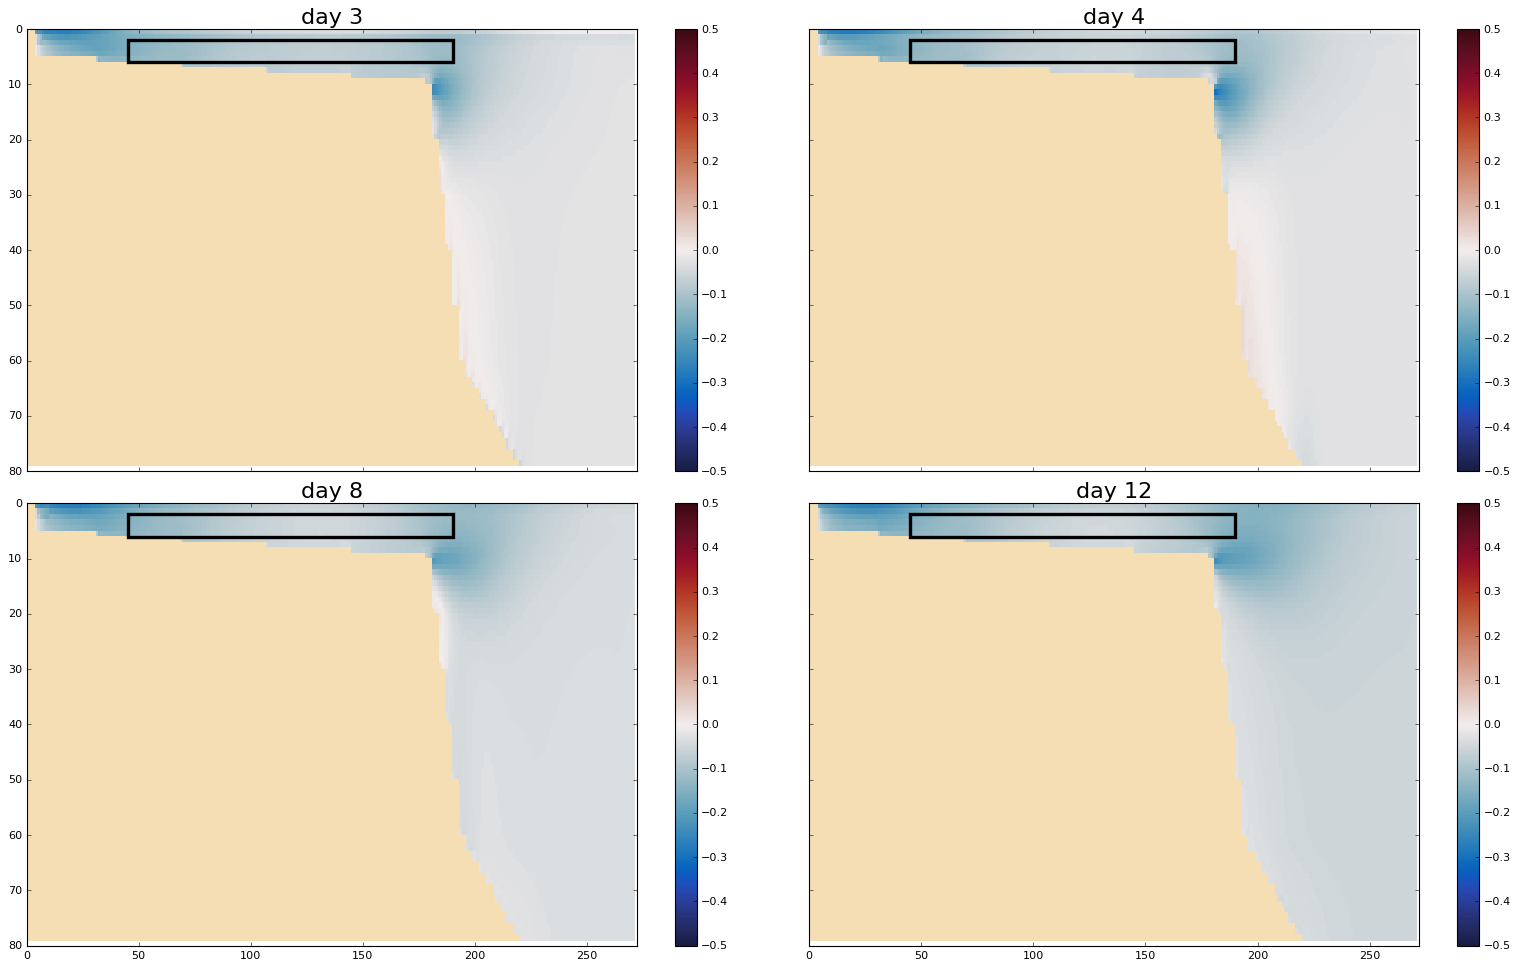

In [78]:
fig = plot_crossU(x_end, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

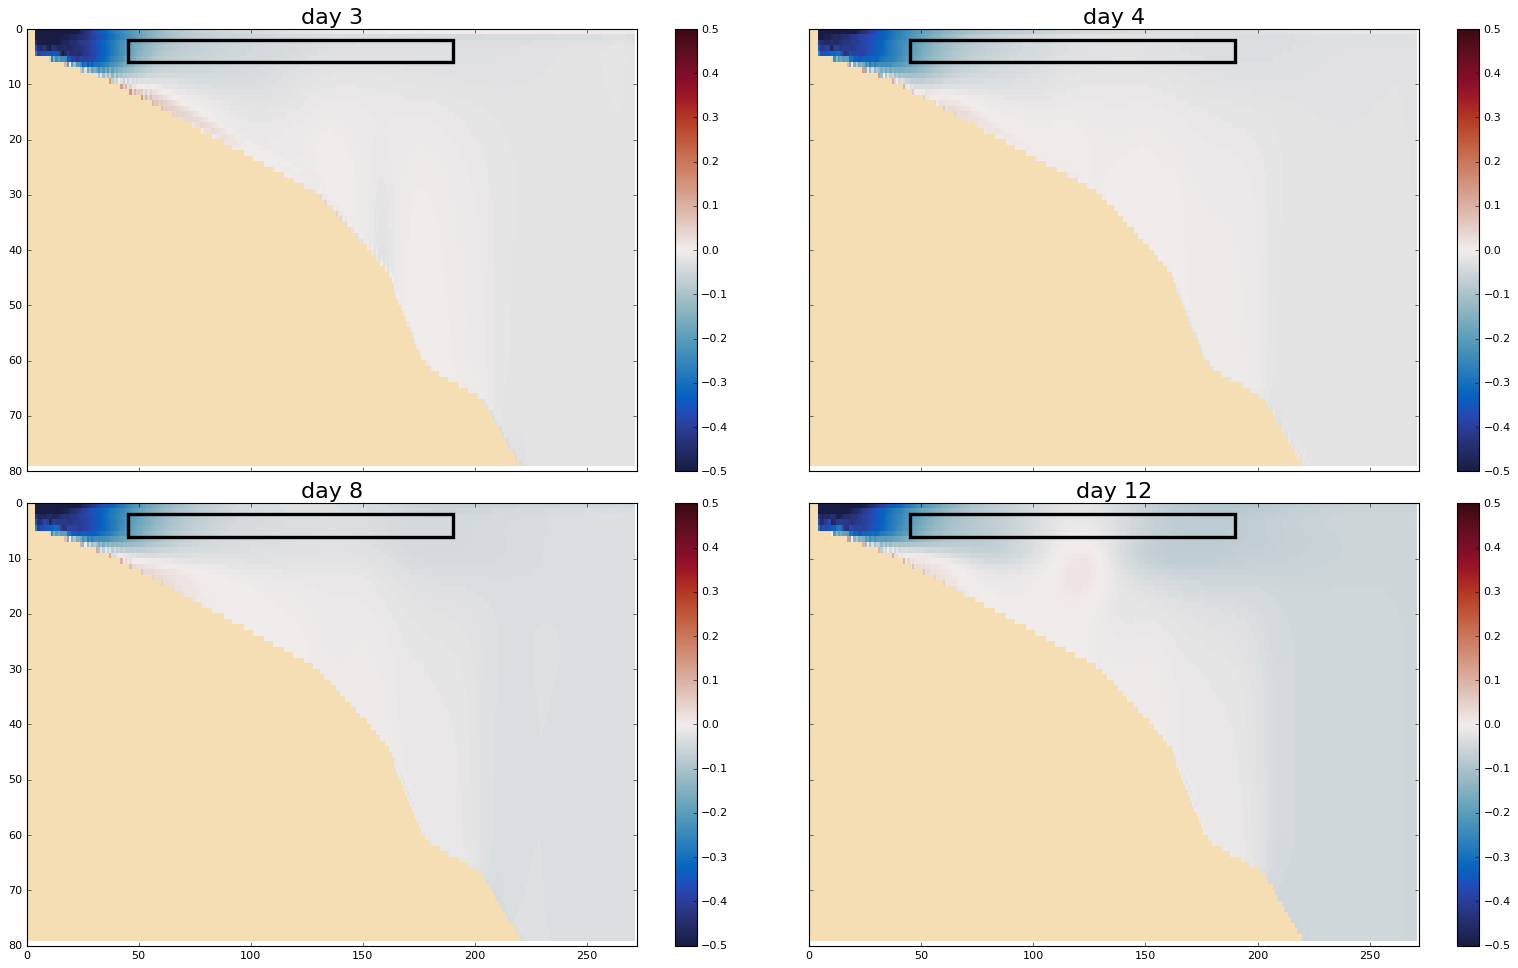

In [79]:
fig = plot_crossU(x_axis, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

## Top profiles of U

In [80]:
def plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day12):
    fig, axes = plt.subplots(2,2,figsize=(20, 12), sharex=True, sharey=True)
    fig.tight_layout(h_pad=2, w_pad=0.2)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    vels = [vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day12]
    ttls = ['day 3', 'day 4', 'day 8', 'day 12']
    for ax, vel, ttl, n in zip(axes.flatten(), vels, ttls, np.arange(4)):
        p = ax.pcolormesh(xs, ys, vel[dep_ind, :, :], cmap=cmap, vmin=-0.5, vmax=0.5)
        ax.set_xlim([0, vel.shape[-1]])
        ax.set_ylim([0, vel.shape[-2]])
        ax.add_patch(patches.Rectangle((x_start, y_start),x_end-x_start,y_end-y_start, fill=False, linewidth=3))
        fig.colorbar(p, ax=ax)
        ax.set_title(ttl+' (dep_ind ' + str(dep_ind)+': '+str(int(depthu[dep_ind]))+'m)', fontsize=20)
    return fig

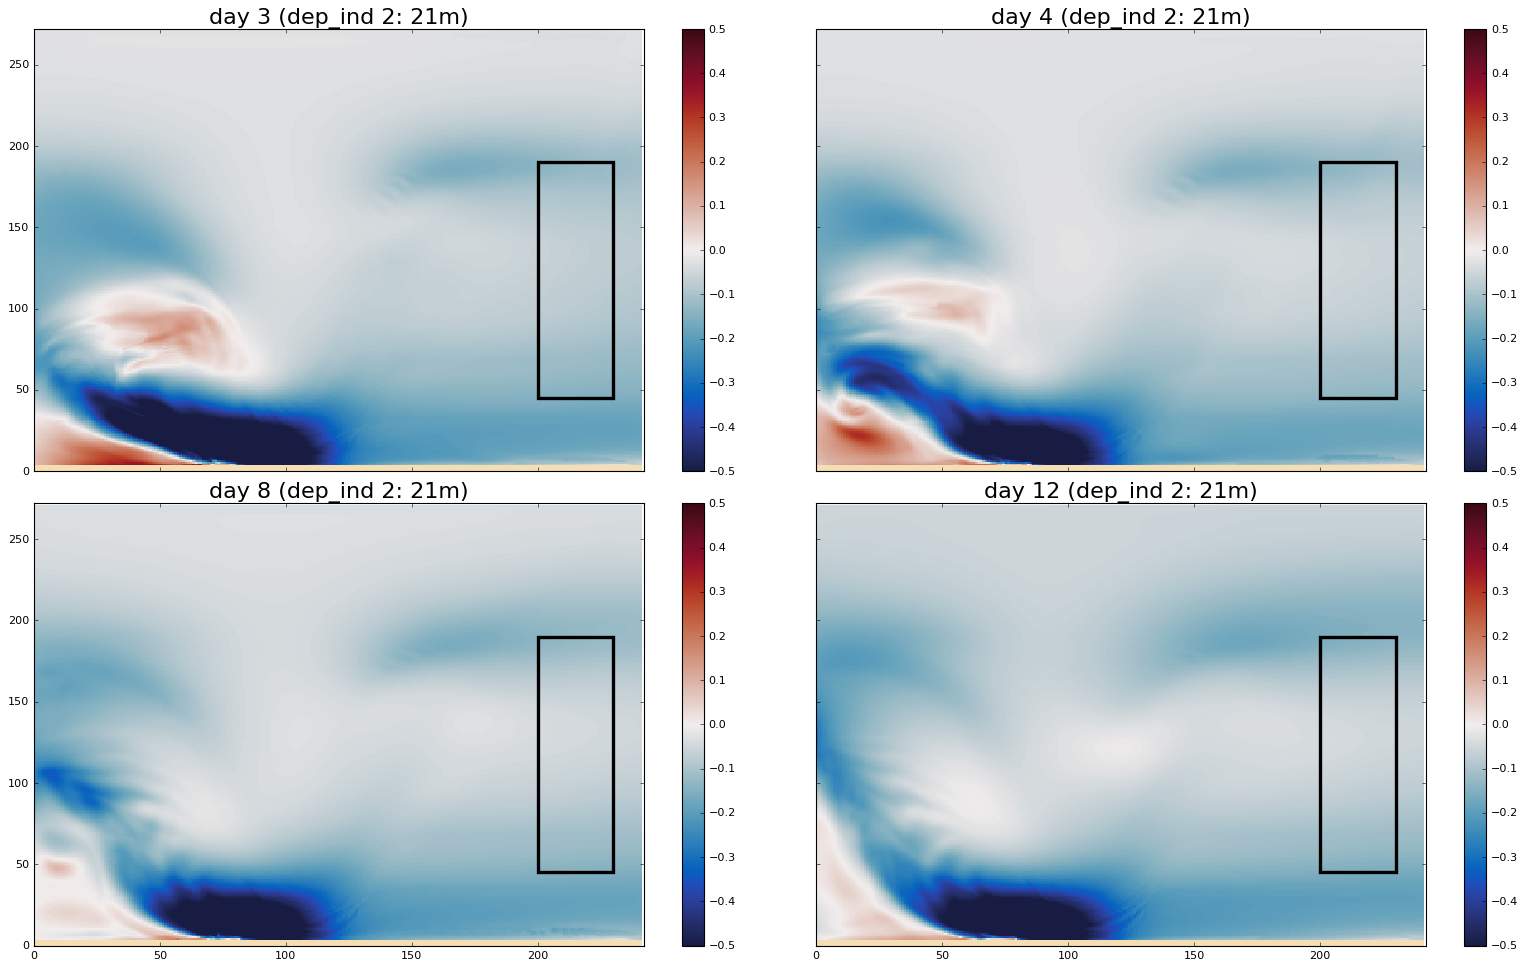

In [81]:
dep_ind = dep_start
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

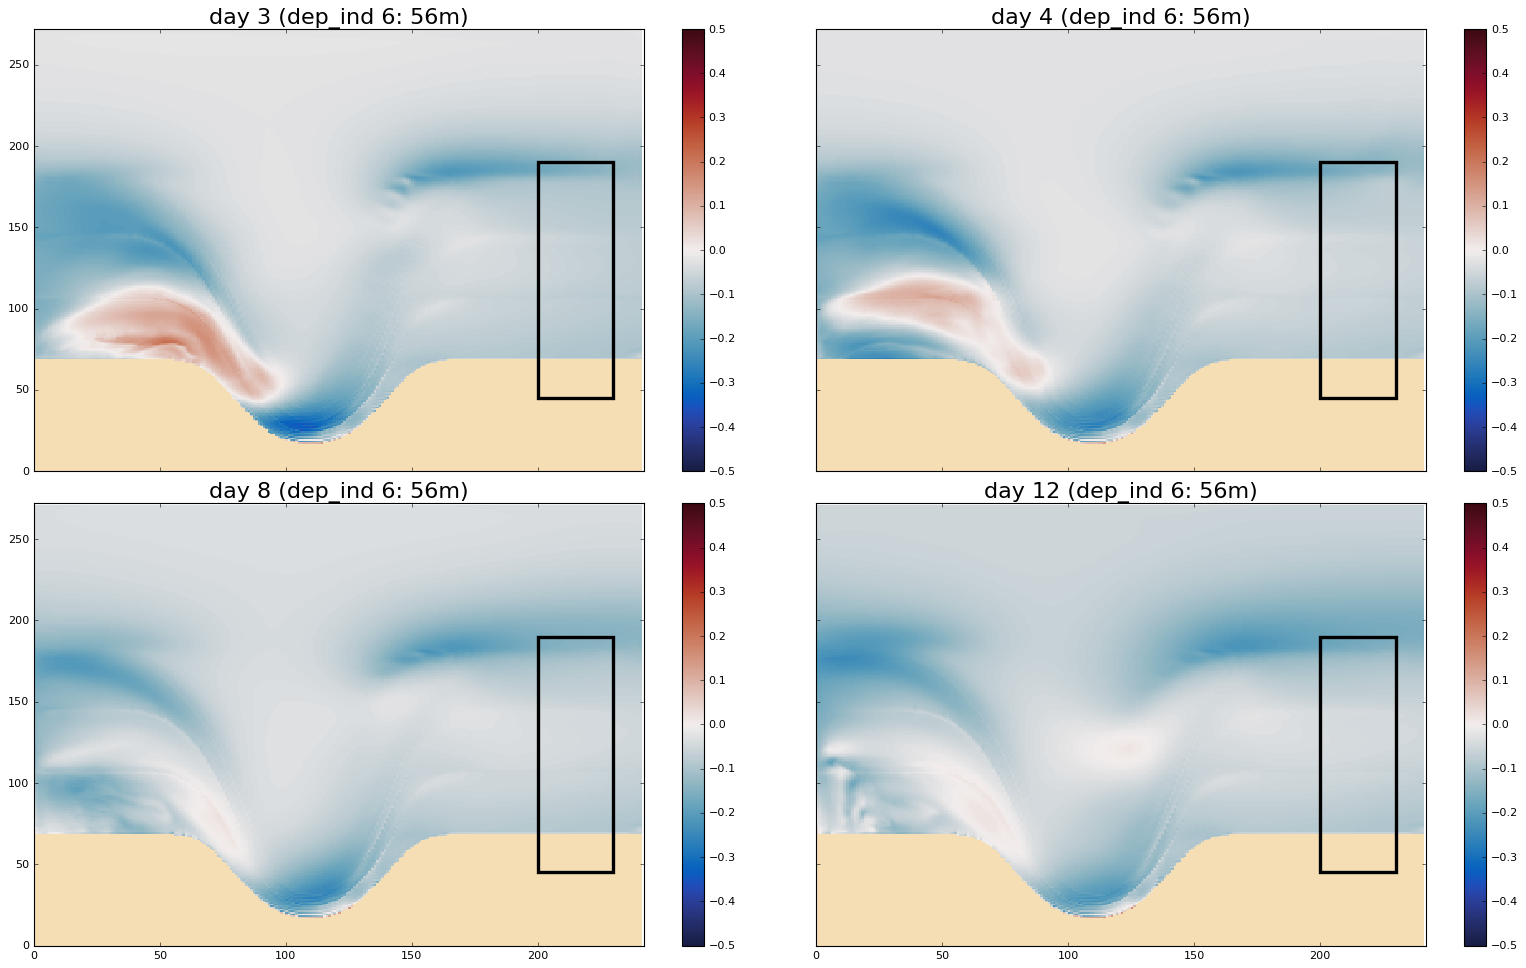

In [82]:
dep_ind = dep_end
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

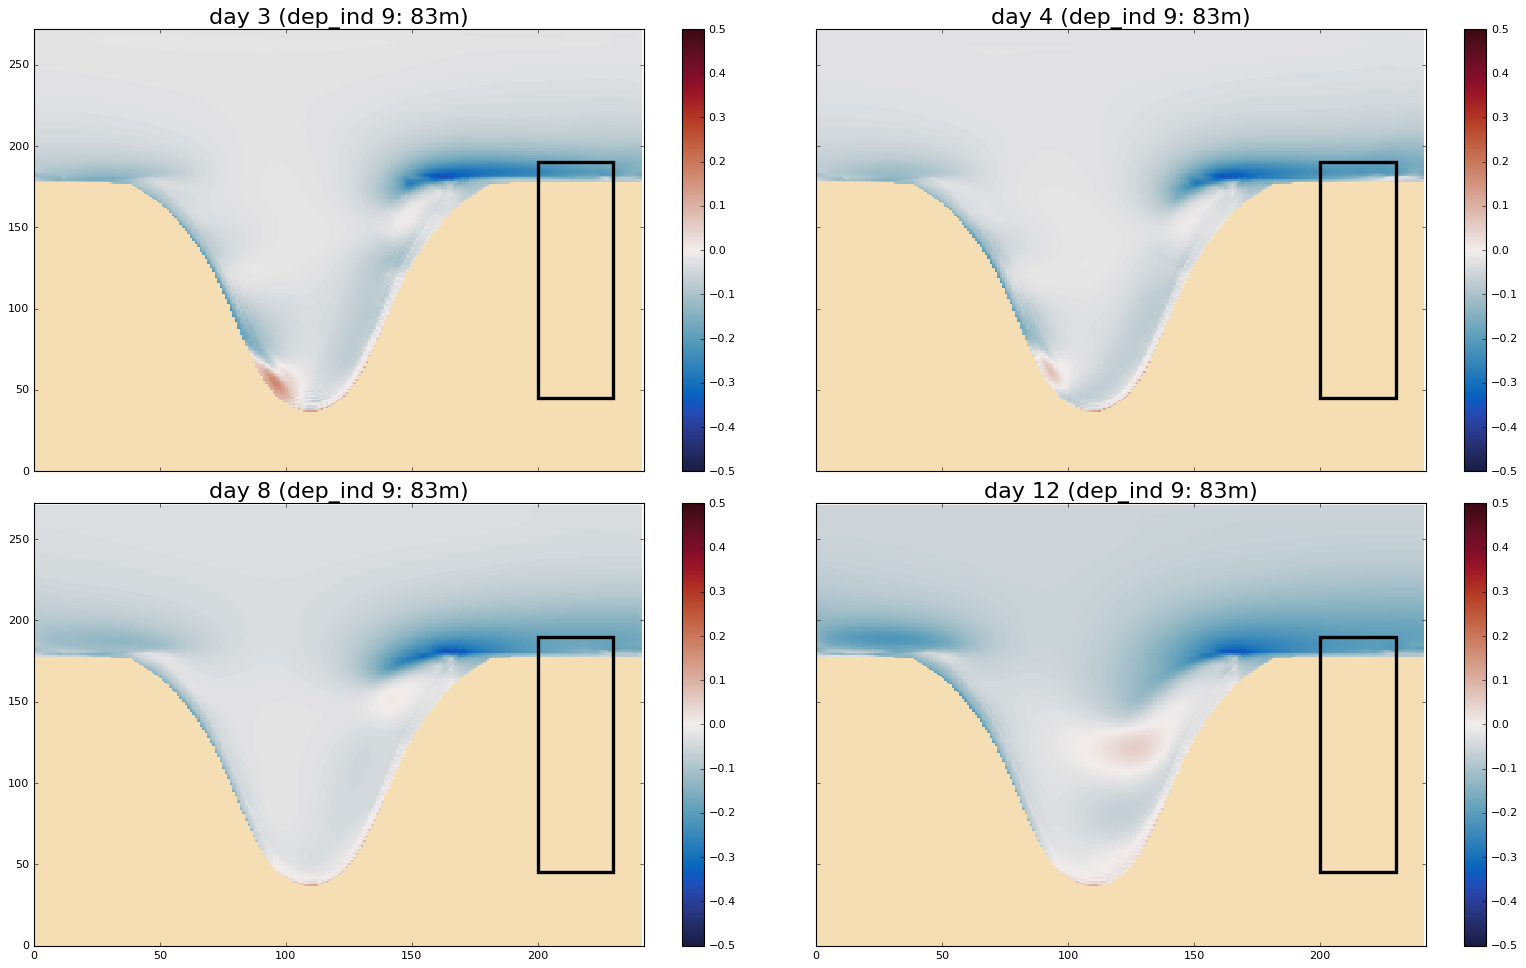

In [83]:
dep_ind = dep_break
fig = plot_topU(dep_ind, vozocrtx_day3, vozocrtx_day4, vozocrtx_day8, vozocrtx_day15)

## Is the incoming flow nearly uniform along the canyon length of the canyon from head to shelf break depth?

In [84]:
rowU = np.mean(vozocrtx, axis=-1)
rowU.shape

(480, 80, 145)

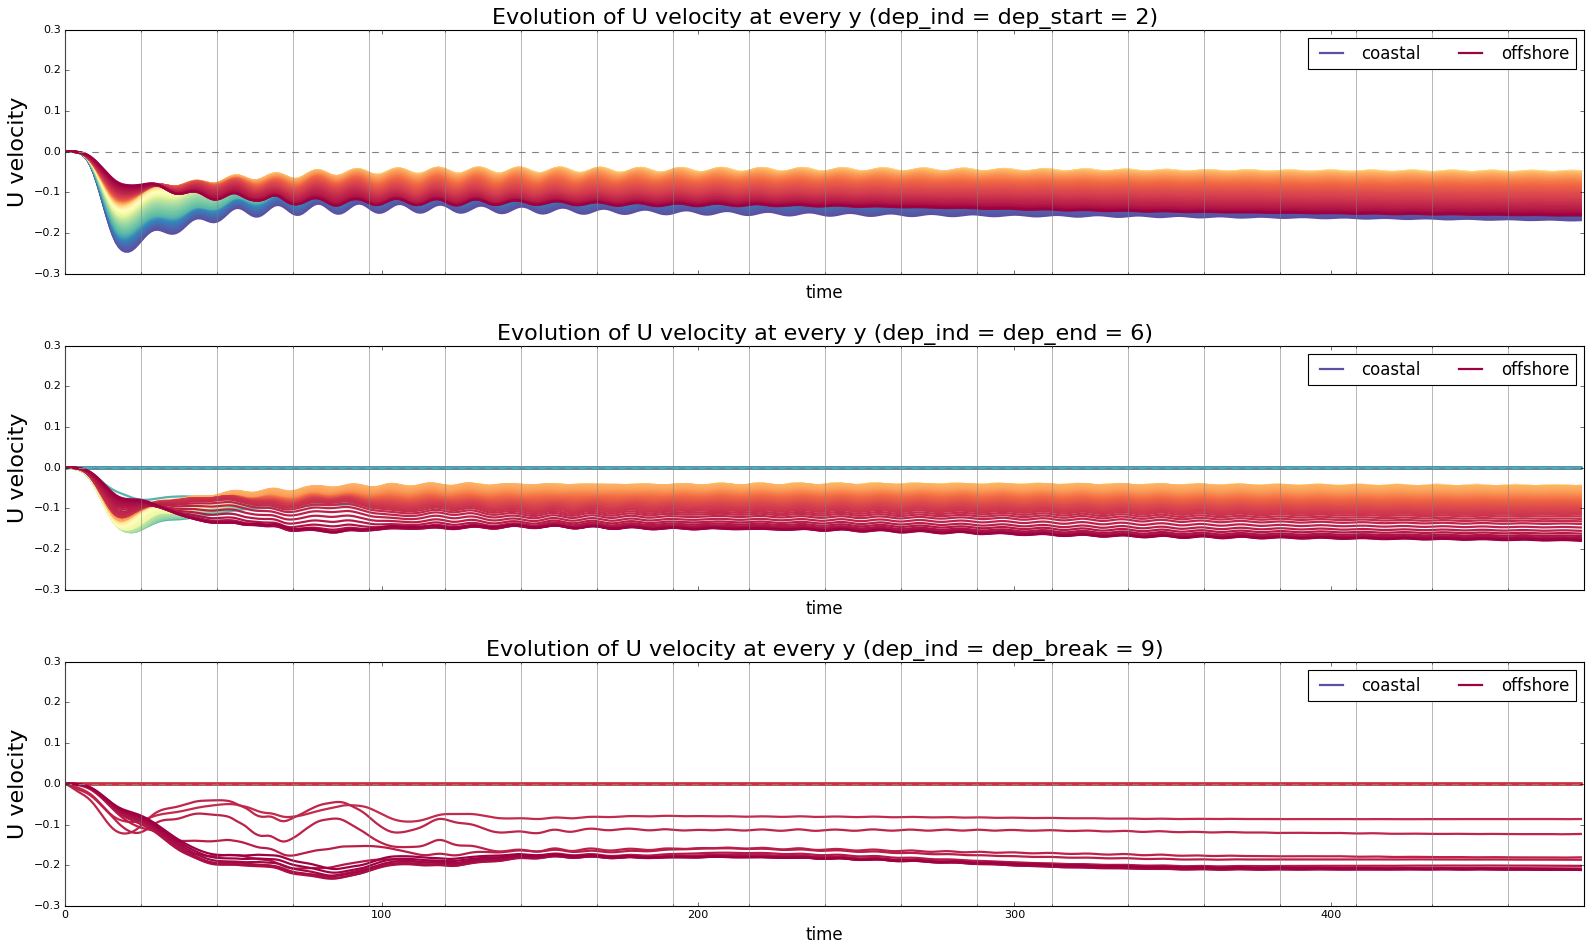

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
cm_times = np.linspace(0, 1, rowU.shape[-1])
colors = [cm.Spectral_r(x) for x in cm_times]

for ax, dep_ind in zip([ax1, ax2, ax3], [dep_start, dep_end, dep_break]):
    for y in range(rowU.shape[-1]):
        if y == 0: 
            ax.plot(general_functions.smooth(rowU[:, dep_ind, y], 1), c=colors[y], lw=2, label='coastal')
        elif y == rowU.shape[-1]-1:
            ax.plot(general_functions.smooth(rowU[:, dep_ind, y], 1), c=colors[y], lw=2, label='offshore')
        else:
            ax.plot(general_functions.smooth(rowU[:, dep_ind, y], 1), c=colors[y], lw=2)
            
ttls = ['dep_start = '+str(dep_start), 'dep_end = '+str(dep_end), 'dep_break = '+str(dep_break)]
for ax, ttl in zip([ax1, ax2, ax3], ttls):
    ax.set_xlabel('time', fontsize=15)
    ax.set_ylabel('U velocity', fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.3, 0.3])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.axhline(0, linestyle='--', c='gray')
    ax.set_title('Evolution of U velocity at every y (dep_ind = '+ttl+')', fontsize=20)
    ax.legend(ncol=2, fontsize=15)
fig.tight_layout(h_pad=2)

In [86]:
avgU_headbreak = avgU[:, dep_start : dep_end+1]
avgU_full = np.mean(avgU_headbreak, axis=-1)

avgU_headbreak.shape, avgU_full.shape

((480, 5), (480,))

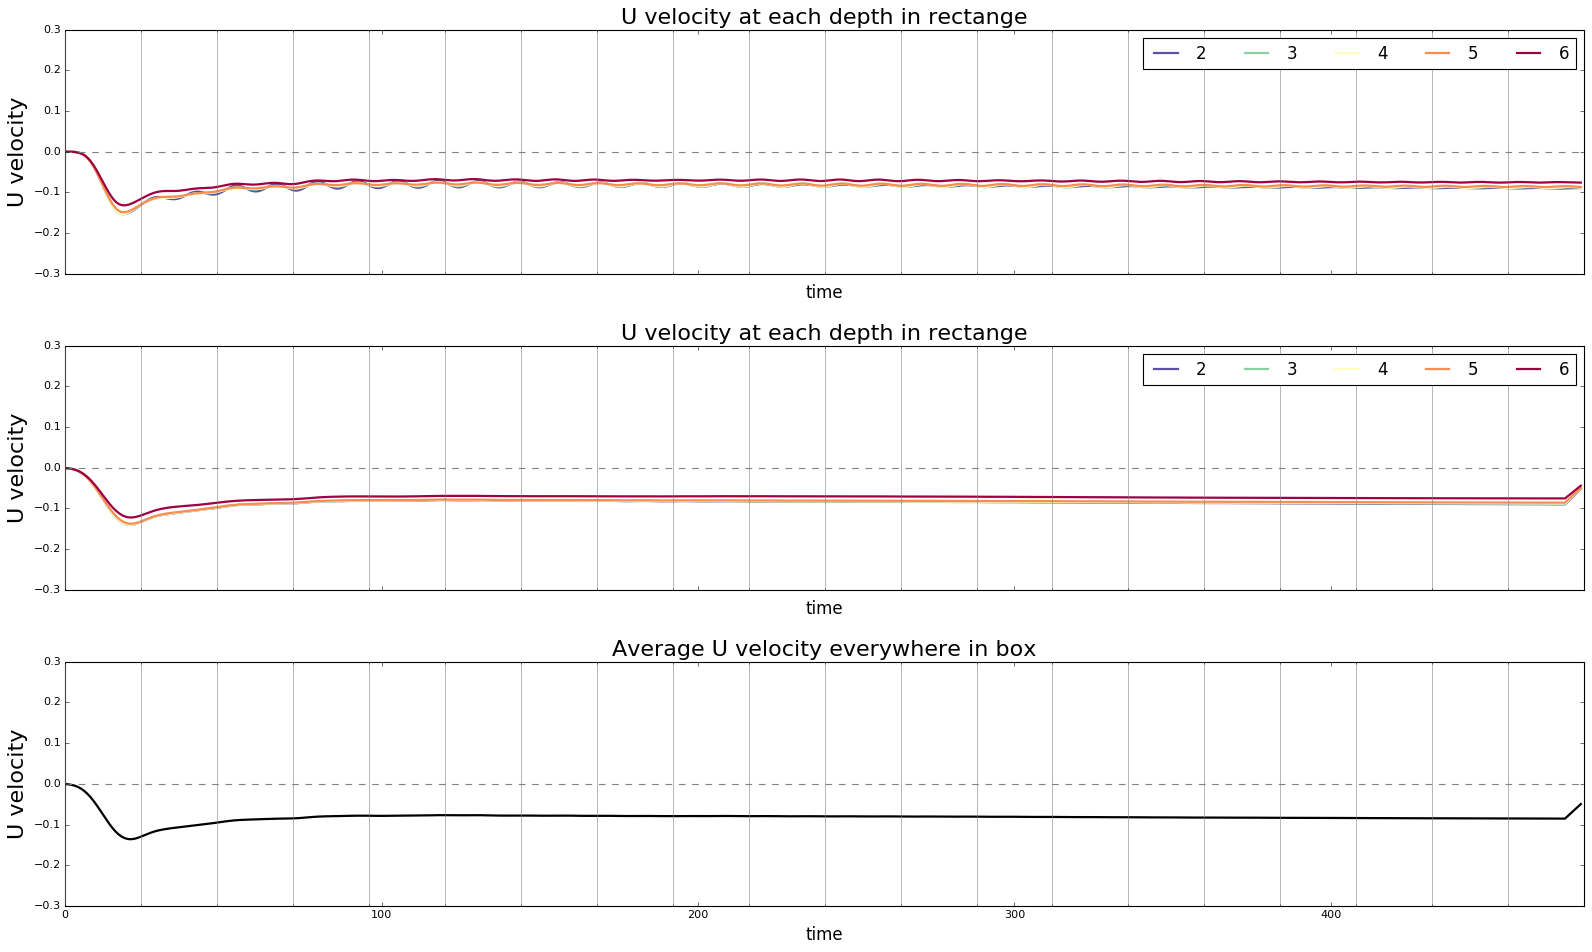

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
cm_times = np.linspace(0, 1, avgU_headbreak.shape[-1])
colors = [cm.Spectral_r(x) for x in cm_times]
dep_inds = np.arange(dep_start,dep_end+1)

for n in range(avgU_headbreak.shape[-1]):
    ax1.plot(general_functions.smooth(avgU_headbreak[:, n], 1), c=colors[n], lw=2, label=str(dep_inds[n]))
    ax2.plot(general_functions.smooth(avgU_headbreak[:, n], 12), c=colors[n], lw=2, label=str(dep_inds[n]))
ax3.plot(general_functions.smooth(avgU_full[:], 12), c='k', lw=2)
 
ttls = ['U velocity at each depth in rectange', 'U velocity at each depth in rectange', 
        'Average U velocity everywhere in box']
for ax, i, ttl in zip([ax1, ax2, ax3], np.arange(3), ttls):
    ax.set_xlabel('time', fontsize=15)
    ax.set_ylabel('U velocity', fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.3, 0.3])
    ml = MultipleLocator(24)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.axhline(0, linestyle='--', c='gray')
    ax.set_title(ttl, fontsize=20)
    ax.legend(ncol=5, fontsize=15)
fig.tight_layout(h_pad=2)

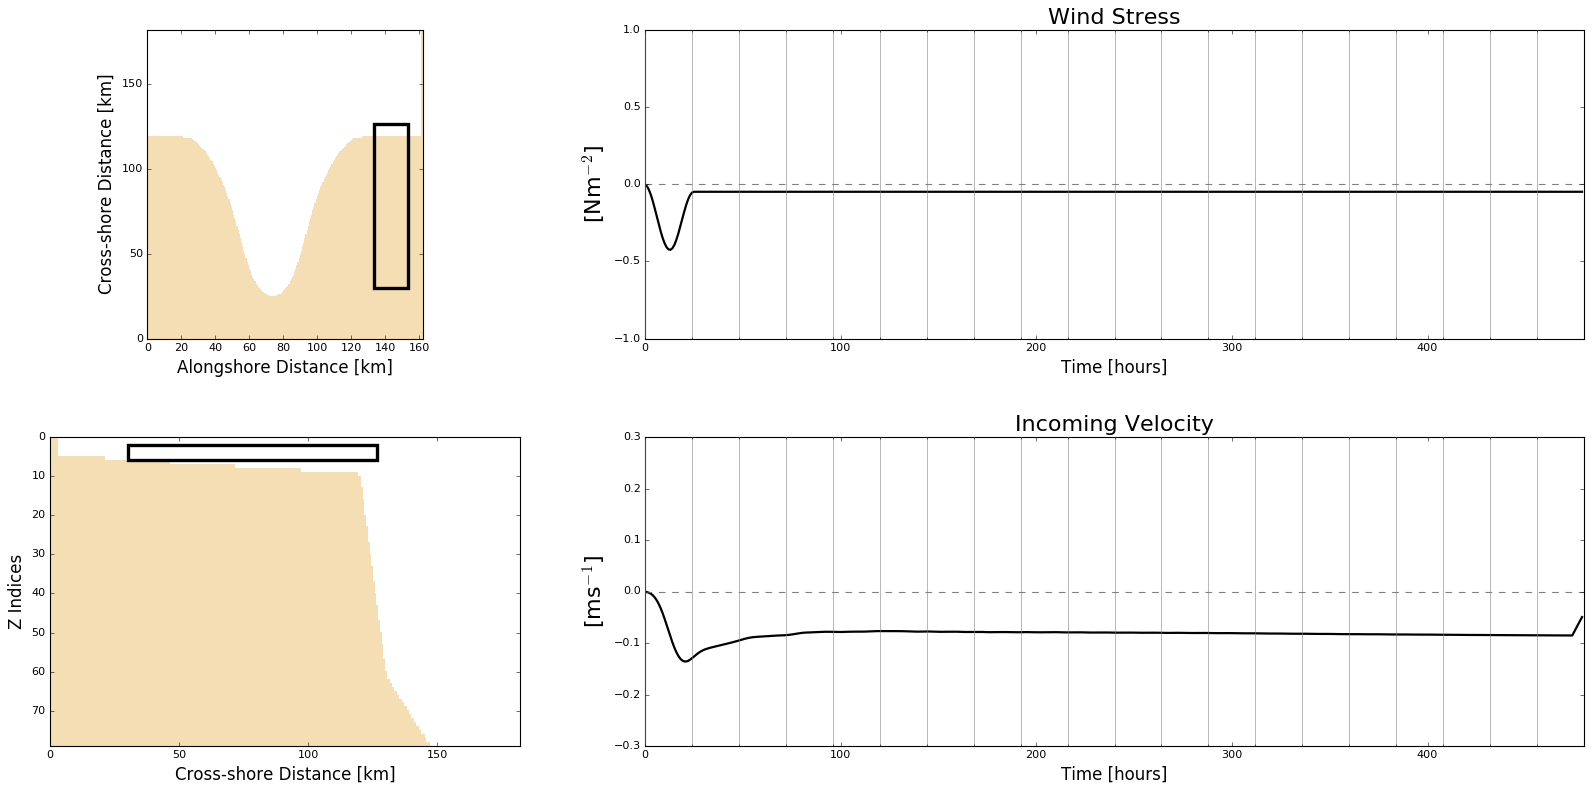

In [88]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

xs = np.arange(umask_all.shape[-1]) * 2/3
ys = np.arange(umask_all.shape[-2]) *2/3
zs = np.arange(umask_all.shape[-3])

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])

ax1 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[3])

s = ax1.pcolormesh(xs, ys, umask_all[9, :,:], cmap=cmap)
ax1.set_aspect(aspect='equal')
ax1.add_patch(patches.Rectangle((x_start*2/3, y_start*2/3),(x_end-x_start)*2/3,(y_end-y_start)*2/3, 
                                fill=False, linewidth=3))
ax1.set_xlim([0, xs[-1]])
ax1.set_ylim([0, ys[-1]])
ax1.set_xlabel('Alongshore Distance [km]', fontsize = 15)
ax1.set_ylabel('Cross-shore Distance [km]', fontsize = 15)

sc = ax3.pcolormesh(ys, zs, umask_all[:, :, x_start], cmap=cmap)
ax3.add_patch(patches.Rectangle((y_start*2/3, dep_start),(y_end-y_start)*2/3, dep_end-dep_start, fill=False, linewidth=3))
ax3.set_ylim([zs[-1], 0])
ax3.set_xlim([0, ys[-1]])
ax3.set_ylabel('Z Indices', fontsize = 15)
ax3.set_xlabel('Cross-shore Distance [km]', fontsize = 15)


avgU_full_smoothed = general_functions.smooth(avgU_full[:], 12)
ax2.plot(avgU_full_smoothed, c='k', lw=2)
ax2.set_title('Incoming Velocity', fontsize=20)
ax2.set_xlabel('Time [hours]', fontsize=15)
ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
ax2.set_xlim([0, 480])
ax2.set_ylim([-0.3, 0.3])
ml = MultipleLocator(24)
ax2.xaxis.set_minor_locator(ml)
ax2.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax2.axhline(0, linestyle='--', c='gray')

ax4.plot(sozotaux, c='k', lw=2)
ax4.set_title('Wind Stress', fontsize=20)
ax4.set_xlabel('Time [hours]', fontsize=15)
ax4.set_ylabel('[Nm$^{-2}$]', fontsize=20)
ax4.set_xlim([0, 480])
ax4.set_ylim([-1.0, 1.0])
ml = MultipleLocator(24)
ax4.xaxis.set_minor_locator(ml)
ax4.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax4.axhline(0, linestyle='--', c='gray')

fig.tight_layout(w_pad=5.5, h_pad=3.5)
fig.savefig('incoming_velocity.png', dpi=fig.dpi)

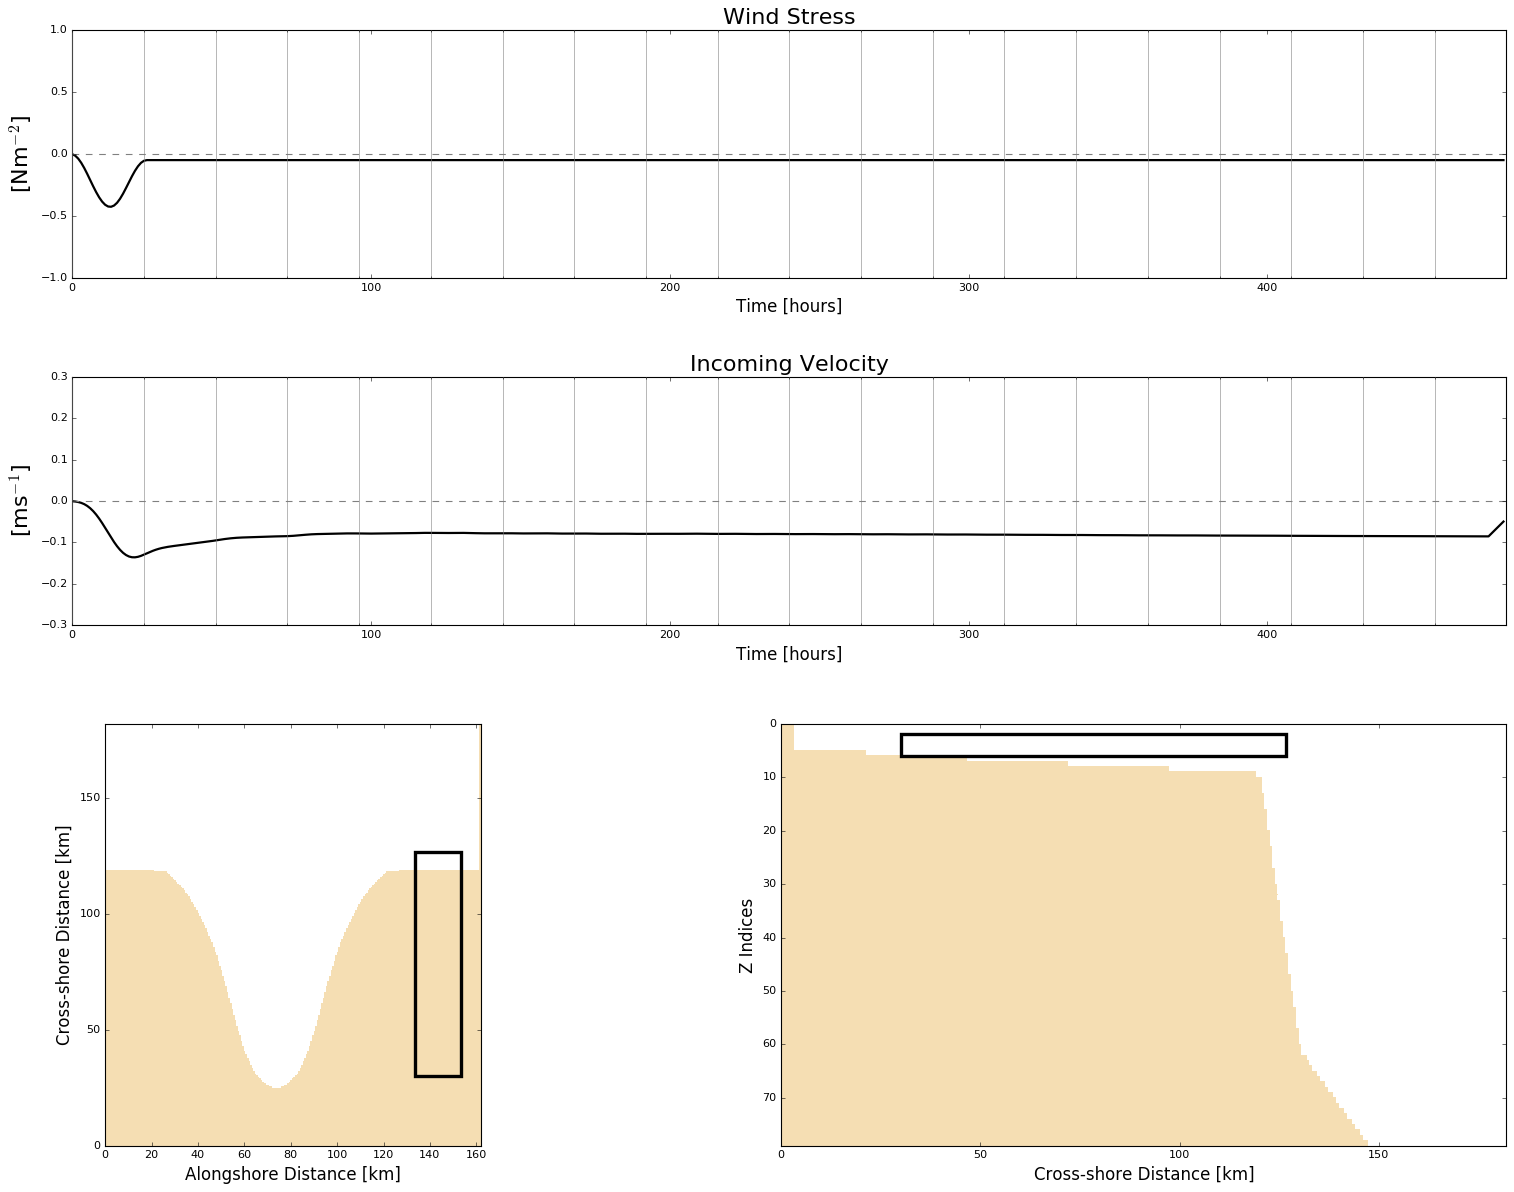

In [89]:
fig = plt.figure(figsize=(20, 15))
ax4 = plt.subplot2grid((7, 12), (0, 1), colspan=12, rowspan=2)
ax2 = plt.subplot2grid((7, 12), (2, 1), colspan=12, rowspan=2)
ax1 = plt.subplot2grid((7, 12), (4, 0), colspan=6, rowspan=3)
ax3 = plt.subplot2grid((7, 12), (4, 6), colspan=6, rowspan=3)


from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

xs = np.arange(umask_all.shape[-1]) * 2/3
ys = np.arange(umask_all.shape[-2]) *2/3
zs = np.arange(umask_all.shape[-3])

s = ax1.pcolormesh(xs, ys, umask_all[9, :,:], cmap=cmap)
ax1.set_aspect(aspect='equal')
ax1.add_patch(patches.Rectangle((x_start*2/3, y_start*2/3),(x_end-x_start)*2/3,(y_end-y_start)*2/3, 
                                fill=False, linewidth=3))
ax1.set_xlim([0, xs[-1]])
ax1.set_ylim([0, ys[-1]])
ax1.set_xlabel('Alongshore Distance [km]', fontsize = 15)
ax1.set_ylabel('Cross-shore Distance [km]', fontsize = 15)

sc = ax3.pcolormesh(ys, zs, umask_all[:, :, x_start], cmap=cmap)
ax3.add_patch(patches.Rectangle((y_start*2/3, dep_start),(y_end-y_start)*2/3, dep_end-dep_start, fill=False, linewidth=3))
ax3.set_ylim([zs[-1], 0])
ax3.set_xlim([0, ys[-1]])
ax3.set_ylabel('Z Indices', fontsize = 15)
ax3.set_xlabel('Cross-shore Distance [km]', fontsize = 15)


avgU_full_smoothed = general_functions.smooth(avgU_full[:], 12)
ax2.plot(avgU_full_smoothed, c='k', lw=2)
ax2.set_title('Incoming Velocity', fontsize=20)
ax2.set_xlabel('Time [hours]', fontsize=15)
ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
ax2.set_xlim([0, 480])
ax2.set_ylim([-0.3, 0.3])
ml = MultipleLocator(24)
ax2.xaxis.set_minor_locator(ml)
ax2.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax2.axhline(0, linestyle='--', c='gray')

ax4.plot(sozotaux, c='k', lw=2)
ax4.set_title('Wind Stress', fontsize=20)
ax4.set_xlabel('Time [hours]', fontsize=15)
ax4.set_ylabel('[Nm$^{-2}$]', fontsize=20)
ax4.set_xlim([0, 480])
ax4.set_ylim([-1.0, 1.0])
ml = MultipleLocator(24)
ax4.xaxis.set_minor_locator(ml)
ax4.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax4.axhline(0, linestyle='--', c='gray')

fig.tight_layout(w_pad=5.5, h_pad=3.5)
fig.savefig('incoming_velocity.png', dpi=fig.dpi)


In [90]:
avgU_full.shape

(480,)

In [91]:
avgU_full.min(), avgU_full.max()

(-0.14794153784814923, 3.6817703296457405e-06)